# 💳 신용카드 예측 EDA

## 목차
(1) 결측치 확인및 데이터 형 변환  

(2) Categorical Variable  EDA  

(3) Numerical Variable EDA

In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from collections import Counter
import warnings
from category_encoders.ordinal import OrdinalEncoder
warnings.filterwarnings('ignore')
plt.rc('font', size=17)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)

In [2]:
#지수출력
# pd.options.display.float_format = '{:.5f}'.format
# #한글 폰트 설정
# matplotlib.rc('font', family = 'Malgun Gothic')
# # 음수 표시 설정
# matplotlib.rc('axes', unicode_minus = False)

In [3]:
#plt.style.available 그래프 스타일 선택
plt.style.use('ggplot') #그래프 스타일 지정

In [4]:
#데이터 불러오기
train = pd.read_csv("train.csv")

In [5]:
train.shape

(26457, 20)

In [6]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

## (1) 결측치 확인및 데이터 전처리

### **결측치 확인**

<AxesSubplot:>

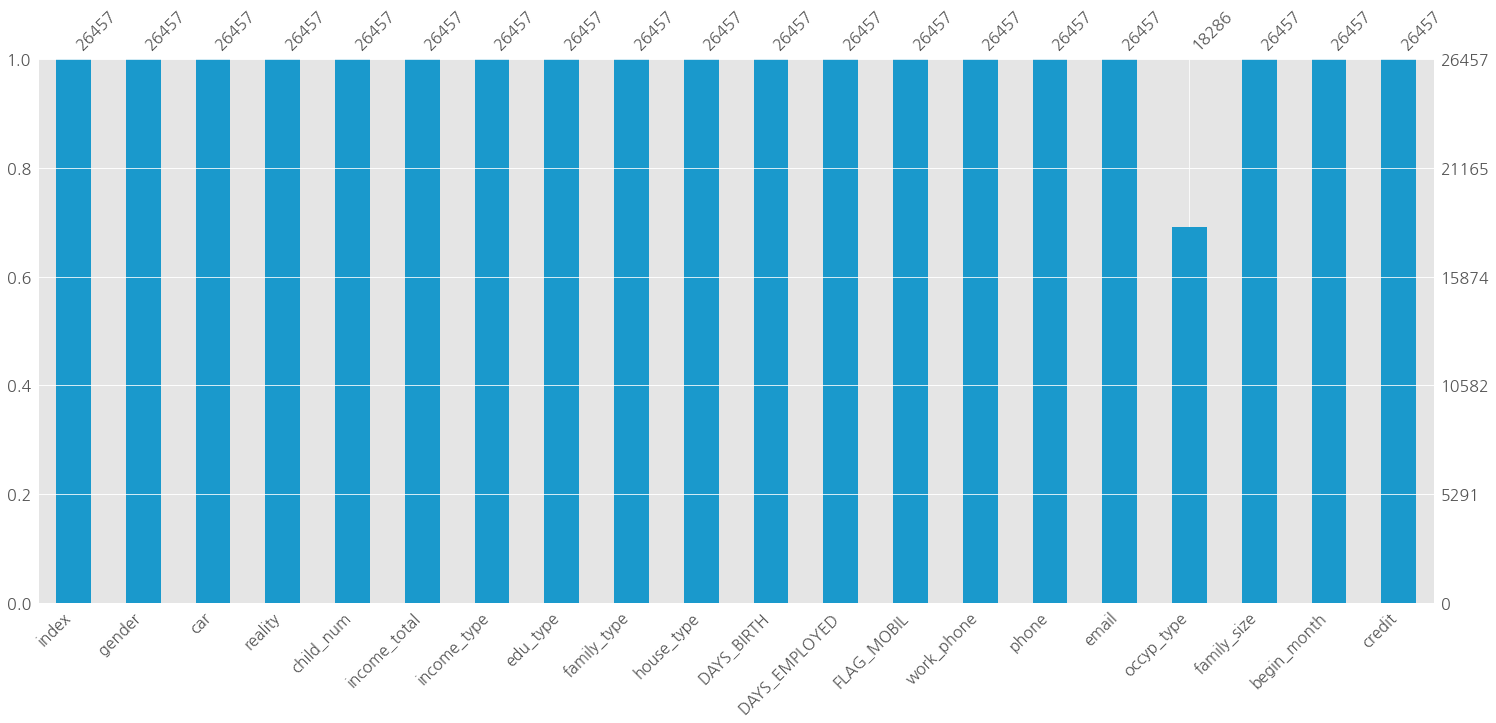

In [7]:
import missingno as msno # 결측치 확인 시각화 툴
msno.bar(df=train.iloc[:, :], color=(0.1, 0.6, 0.8))

- 직업 유형 변수에서 결측치가 존재한다.


### 데이터 전처리

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [9]:
# credit 형 변환
train = train.astype({'credit': 'object'})
print(train.dtypes)

index            int64  
gender           object 
car              object 
reality          object 
child_num        int64  
income_total     float64
income_type      object 
edu_type         object 
family_type      object 
house_type       object 
DAYS_BIRTH       int64  
DAYS_EMPLOYED    int64  
FLAG_MOBIL       int64  
work_phone       int64  
phone            int64  
email            int64  
occyp_type       object 
family_size      float64
begin_month      float64
credit           object 
dtype: object


In [10]:
# 직업 결측값 처리 -> 직업이 없고, 노동시간이 있으면 freelancer, 노동시간이 없으면 inoccupation
train.fillna('NaN', inplace=True)
train['occyp_type'] = np.where((train['occyp_type']=='NaN')&(train['DAYS_EMPLOYED']<0),'freelancer',train['occyp_type'])
train['occyp_type']=train['occyp_type'].replace('NaN','inoccupation')

In [11]:
#가족구성원 결측값 처리 ->  singe이고 아이가 있으면 Widow
train['family_type']=np.where((train['family_type']=='Single / not married')&(train['child_num']!=0),'Widow',train['family_type'])

In [12]:
#연간 소득데이터를 로그값으로 스케일링
train['income_total_log1p'] = np.log1p(1+train['income_total'])

In [13]:
#train['family_size'] > 7 인 데이터 제거 (1등코드)
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

In [14]:
#의미없는 데이터 index, FLAG_MOBIL 삭제
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

## (2) Categorical Variable EDA

### **％ 신용 등급 비율 분포**

In [15]:
train['credit'].value_counts()

2.0    16962
1.0    6267 
0.0    3222 
Name: credit, dtype: int64

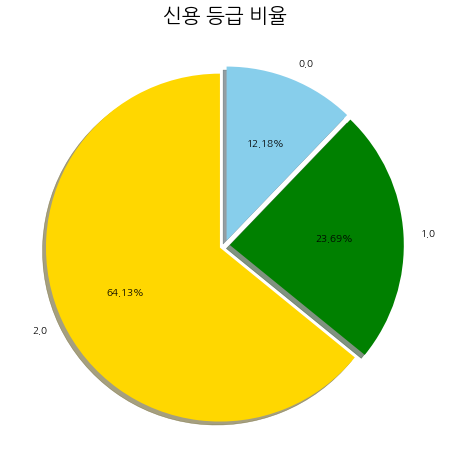

In [16]:
plt.subplots(figsize = (8,8))
explode = [0.03, 0.03, 0.03]
colors = ['gold', 'green', 'skyblue']
wedgeprops={'width': 1, 'edgecolor': 'w', 'linewidth': 5}
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90, explode = explode, colors=colors)
plt.title('신용 등급 비율', size=20)
plt.show()

- 낮을수록 높은 신용의 신용카드 사용자. 낮은 신용도를 가진 사용자가 많다.

In [17]:
# 등급에 따른 차이를 보기 위한 데이터 분류
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]

신용 등급에 따른 차이를 알아보기 위해 다음과 같이 데이터를 분리

In [18]:
# Categorical 그래프 함수 정의
def cat_plot(column):

  f, ax = plt.subplots(3, 1, figsize=(16, 10))


  sns.countplot(y = column,
                data = train_0,
                ax = ax[0],
                order = train_0[column].value_counts().index[:5])
  ax[0].tick_params(labelsize=15)
  ax[0].set_title('credit = 0')
  ax[0].set_xlabel('count')
  ax[0].tick_params(rotation=0)


  sns.countplot(y = column,
                data = train_1,
                ax = ax[1],
                order = train_1[column].value_counts().index[:5])
  ax[1].tick_params(labelsize=15)
  ax[1].set_title('credit = 1')
  ax[1].set_xlabel('count')
  ax[1].tick_params(rotation=0)

  sns.countplot(y = column,
                data = train_2,
                ax = ax[2],
                order = train_2[column].value_counts().index[:5])
  ax[2].tick_params(labelsize=16)
  ax[2].set_title('credit = 2')
  ax[2].set_xlabel('count')
  ax[2].tick_params(rotation=0)
  plt.subplots_adjust(wspace=0.2, hspace=1)
  plt.show()

### 👨👩**신용 등급에 따라 성별의 차이**

In [19]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'credit', 'income_total_log1p'],
      dtype='object')

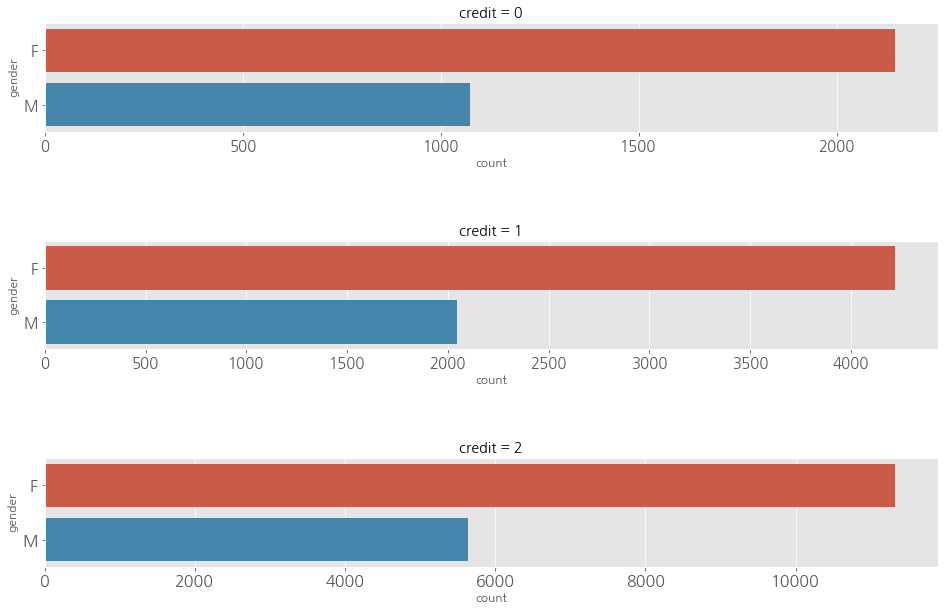

In [20]:
cat_plot("gender")

- 모든 등급에서 남성보다 여성이 더 많았다.

### 🚗 **신용 등급에 따라 차량 소유 차이가 존재할까?**

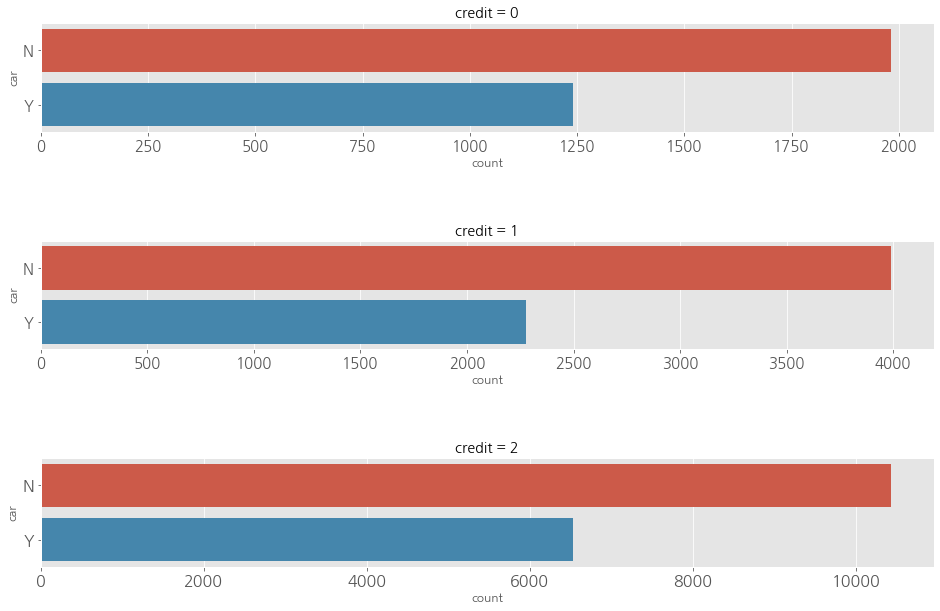

In [21]:
cat_plot('car')

- 모든 등급에서 차를 보유하고 있지 않은 고객들이 많았다.

### 🏠 **신용 등급에 따라 부동산 소유 차이가 존재할까?**

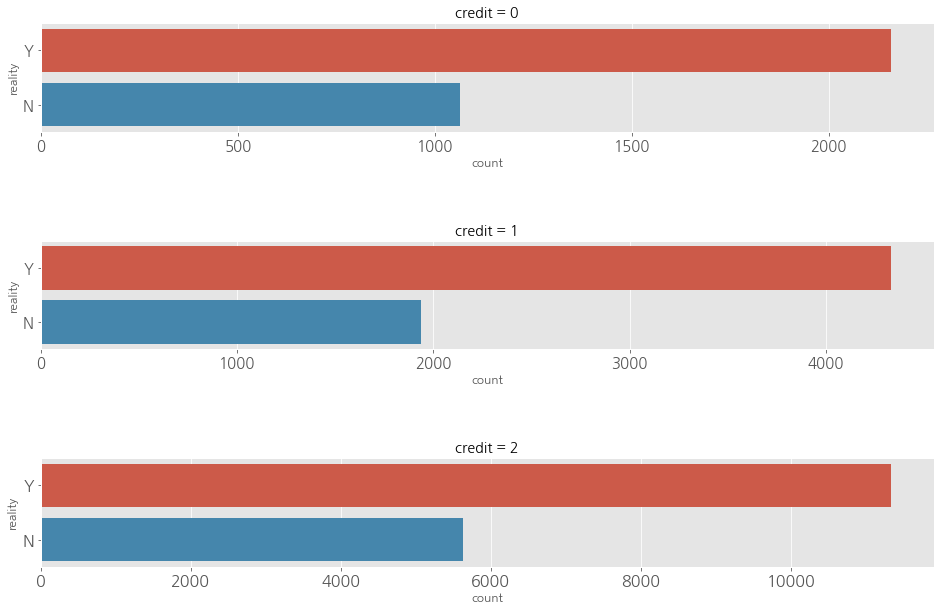

In [22]:
cat_plot('reality')

- 모든 등급에서 부동산을 소유한 사람들이 많았다. 딱히 등급에 따른 차이가 존재하지 않는다.

### 💶 **신용 등급에 따라 소득 분류의 차이가 존재할까?**

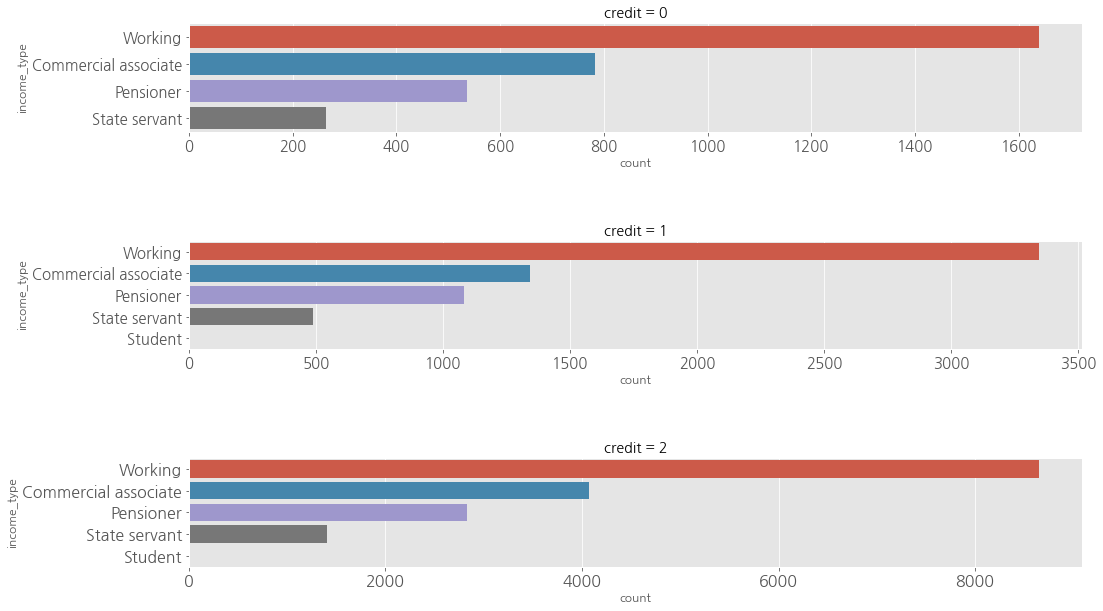

In [23]:
cat_plot('income_type') 

- 높은 신용에서는 학생이 존재하지 않았다. 학생의 신분 특성상 높은 신용을 가지고 있기는 어렵기 때문에 다음과 같은 결과가 나왔다고 생각한다.
- 반면 낮은 신용에서는 학생들이 조금씩 존재했다.

### 🎓**신용 등급에 따라 교육 수준 차이가 존재할까?**

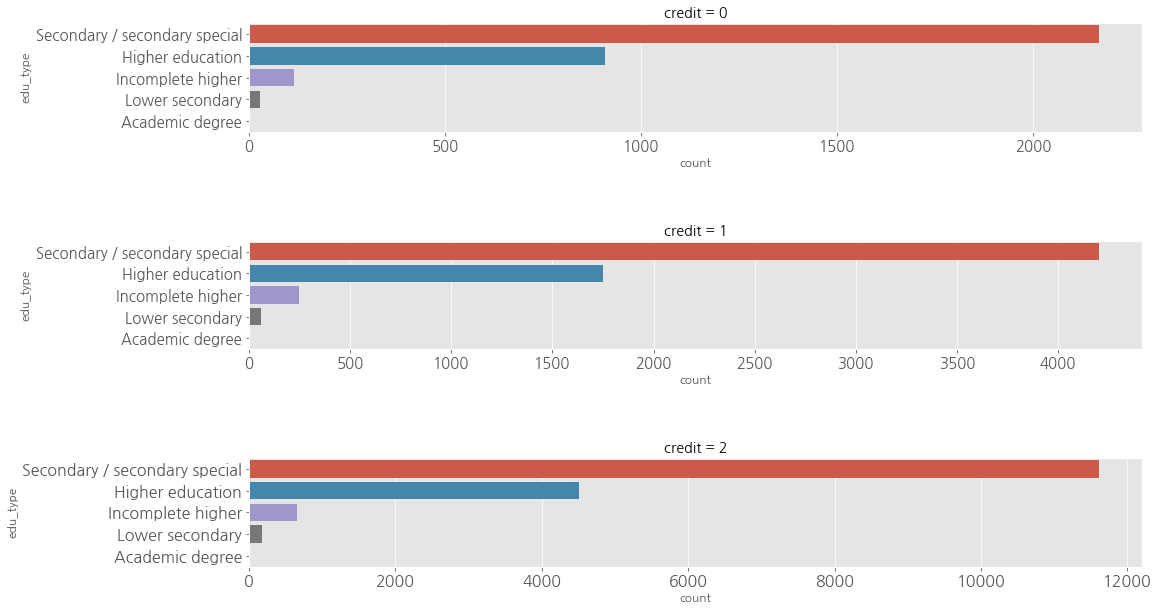

In [24]:
cat_plot('edu_type')

- 모든 등급에서 교육 수준의 순위가 같았다.

### 👰🏻🤵🏻‍♂️**신용 등급에 따라 결혼 여부 차이가 존재할까?**

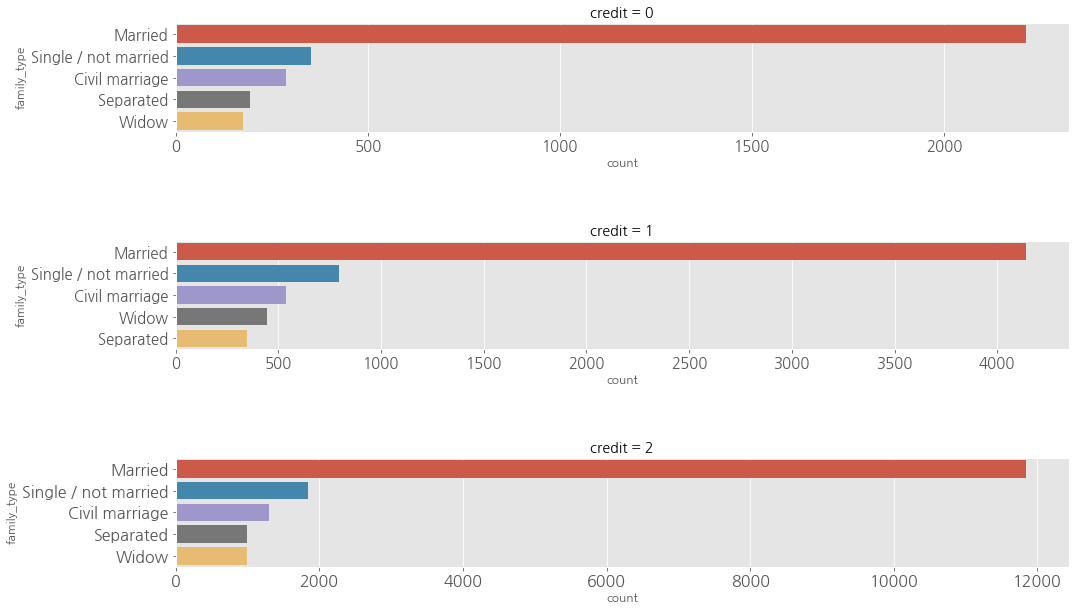

In [25]:
cat_plot('family_type')

- 모든 등급에서 결혼을 한 사람들이 가장 많았다.
- 결혼을 한 사람들이 상대적으로 많이 존재한다.


### 🏘 **신용 등급에 따라 생활 방식 차이가 존재할까?**

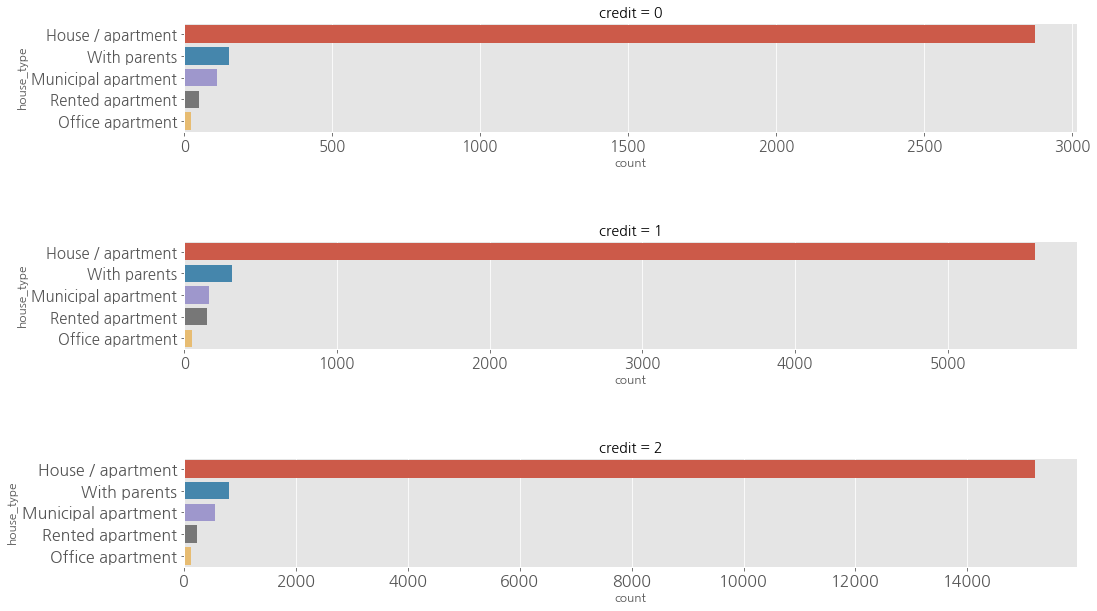

In [26]:
cat_plot('house_type')

- 모든 등급에서 교육 수준의 순위가 같았다.

### ☎️ **신용 등급에 따라 가정용 전화 소유 차이가 존재할까?**

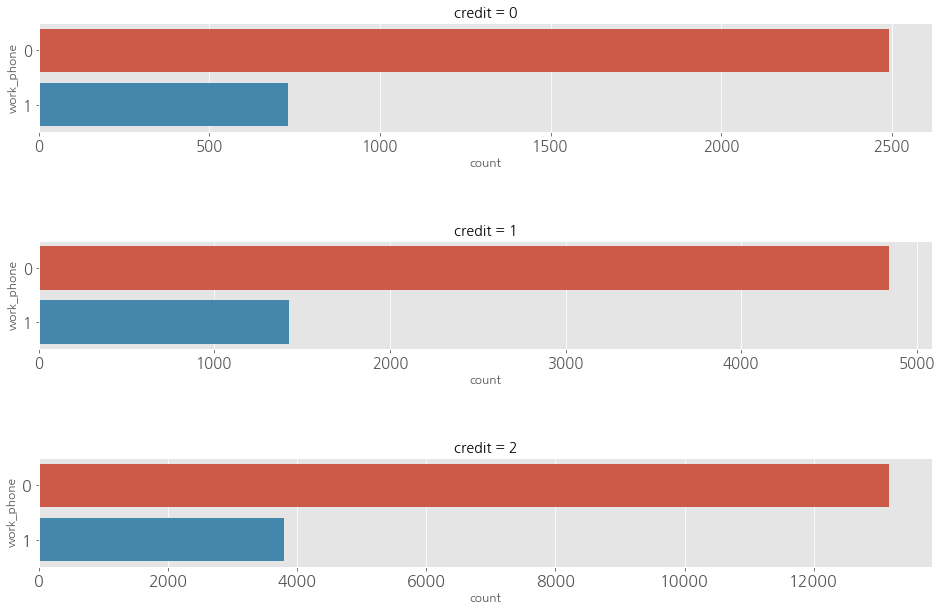

In [27]:
cat_plot('work_phone')

- 모든 등급에서 가정용 전화를 소유하고 있지 않는 사람들이 많았다.
- 요즘은 휴대용 핸드폰을 많이 사용하기 때문에 다음과 같은 결과가 나왔다고 생각한다.


### 📨**신용 등급에 따라 이메일 소유 차이가 존재할까?**

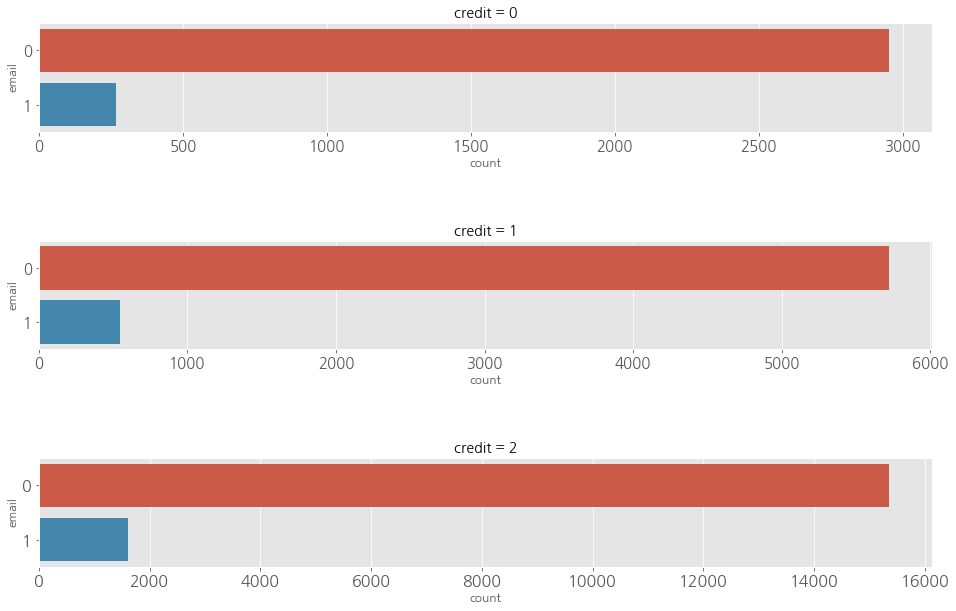

In [28]:
cat_plot('email')

- 모든 등급에서 이메일을 소유한 사람들이 훨씬 많았다.

###👶🏻 **신용 등급에 따라 자녀수의 차이가 존재할까?**

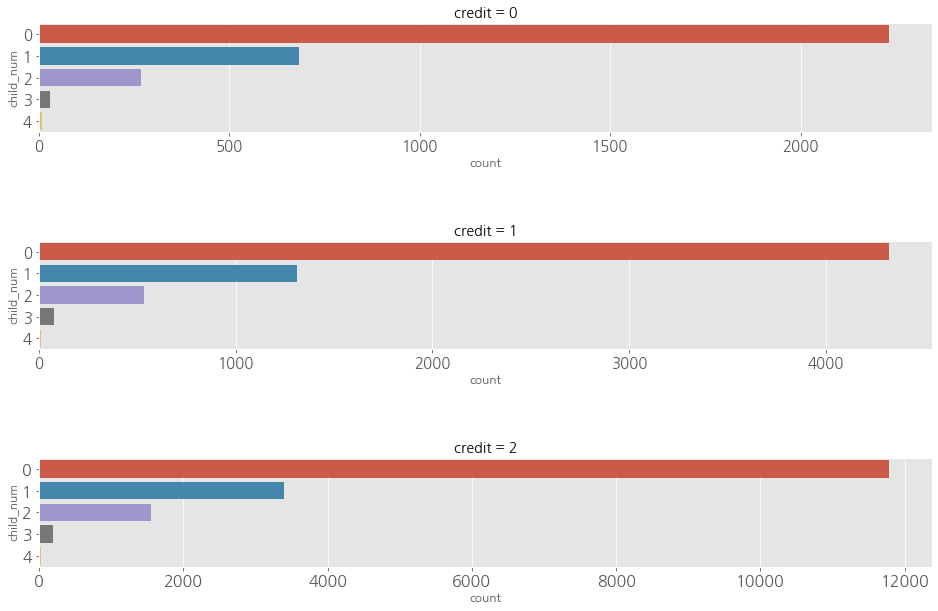

In [29]:
cat_plot('child_num')

- 자녀의 수도 별다른 차이가 없어 보인다.



### 🏃🏻‍♂️**신용 등급에 따라 직업 유형 차이가 존재할까?**

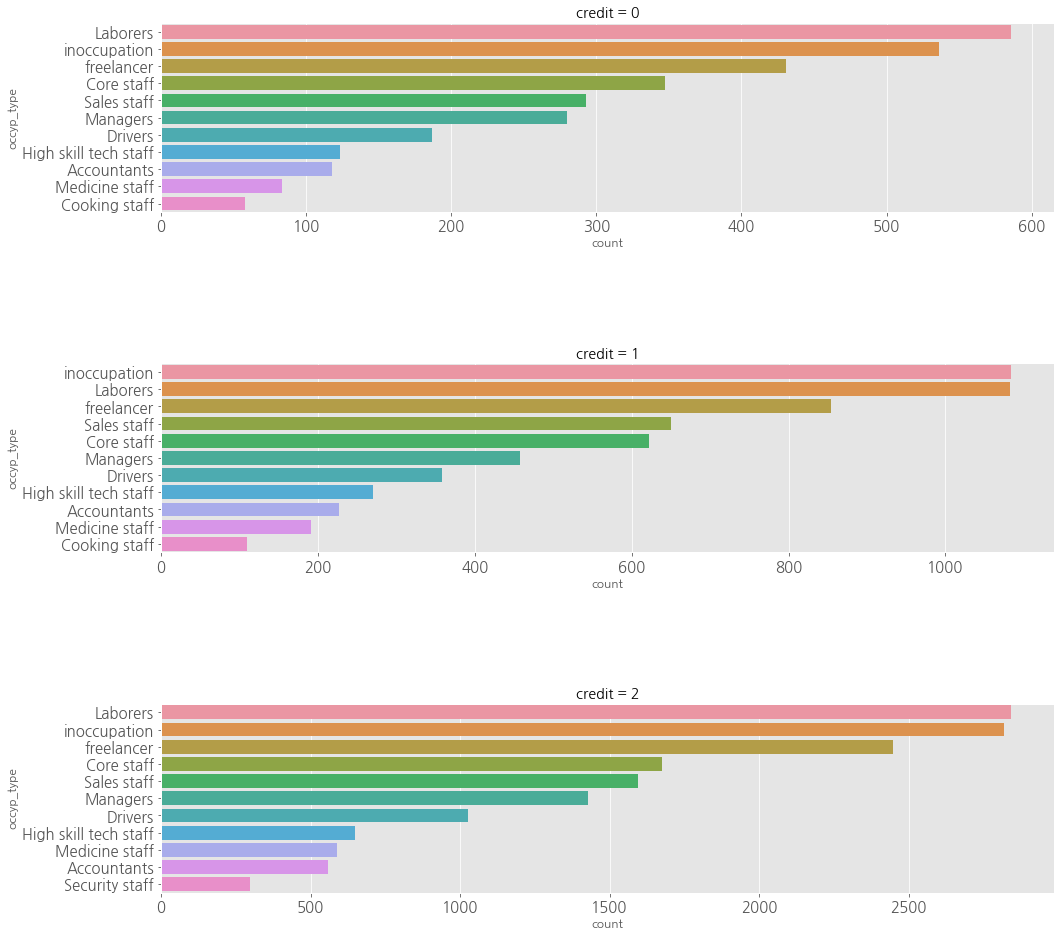

In [30]:
f, ax = plt.subplots(3, 1, figsize=(16, 16))
sns.countplot(y = 'occyp_type', data = train_0, order = train_0['occyp_type'].value_counts().index[:11], ax=ax[0])
ax[0].tick_params(labelsize=15)
ax[0].set_title('credit = 0')
sns.countplot(y = 'occyp_type', data = train_1, order = train_1['occyp_type'].value_counts().index[:11], ax=ax[1])
ax[1].tick_params(labelsize=15)
ax[1].set_title('credit = 1')
sns.countplot(y = 'occyp_type', data = train_2, order = train_2['occyp_type'].value_counts().index[:11], ax=ax[2])
ax[2].tick_params(labelsize=15)
ax[2].set_title('credit = 2')
plt.subplots_adjust(wspace=0.5, hspace=0.8)
plt.show()

- 등급별로 직업 유형의 순위 변동이 조금 존재합니다.


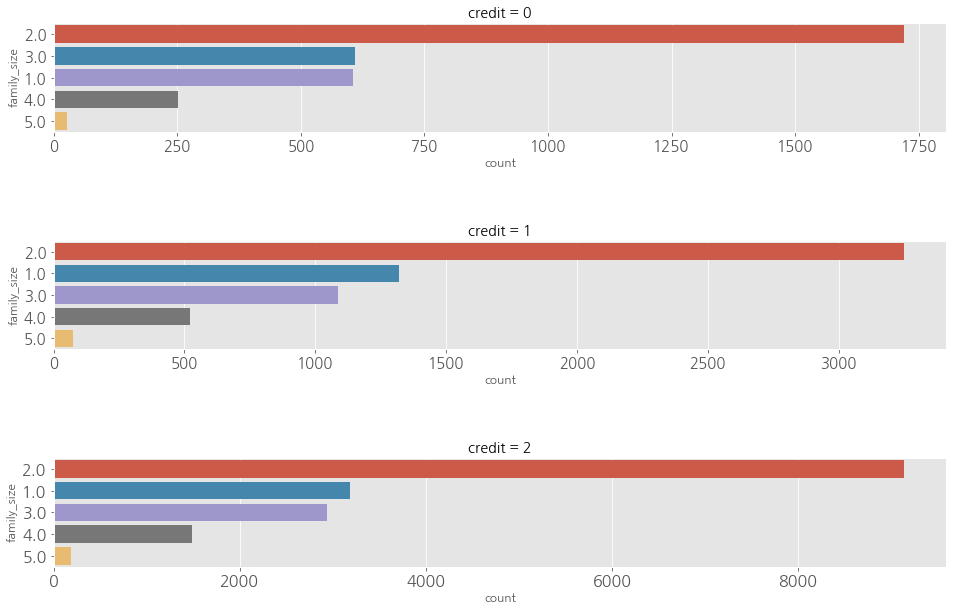

In [31]:
cat_plot("family_size")

- 보통 가족 수가 2명인 사람들이 많았습니다.
- 결혼한 사람들이 많았던 결과와 연관되는 결과입니다.
- 2등급에서는 1,2에 비해 왼쪽으로 치우진 그래프가 나왔습니다.


## (3) Numerical Variable EDA

In [32]:
# Numerical 그래프 함수 정의
def num_plot(column):
  
  fig, axes = plt.subplots(3, 1, figsize=(10, 16))

  sns.histplot(train_0[column],
                ax = axes[0], kde = True, bins = 20)
  axes[0].ticklabel_format(style='plain', axis='x')  
  axes[0].tick_params(labelsize=12)
  axes[0].set_title('credit = 0')
  axes[0].set_ylabel('count')

  sns.histplot(train_1[column],
                ax = axes[1], kde = True)
  axes[1].tick_params(labelsize=12)
  axes[1].ticklabel_format(style='plain', axis='x')  
  axes[1].set_title('credit = 1')
  axes[1].set_ylabel('count')

  sns.histplot(train_2[column],
                ax = axes[2], kde = True)
  axes[2].tick_params(labelsize=12)
  axes[2].ticklabel_format(style='plain', axis='x')  
  axes[2].set_title('credit = 2')
  axes[2].set_ylabel('count')
  plt.subplots_adjust(wspace=0.3, hspace=0.3)

### 💰 **신용 등급에 따라 연간 소득 차이가 존재할까?**

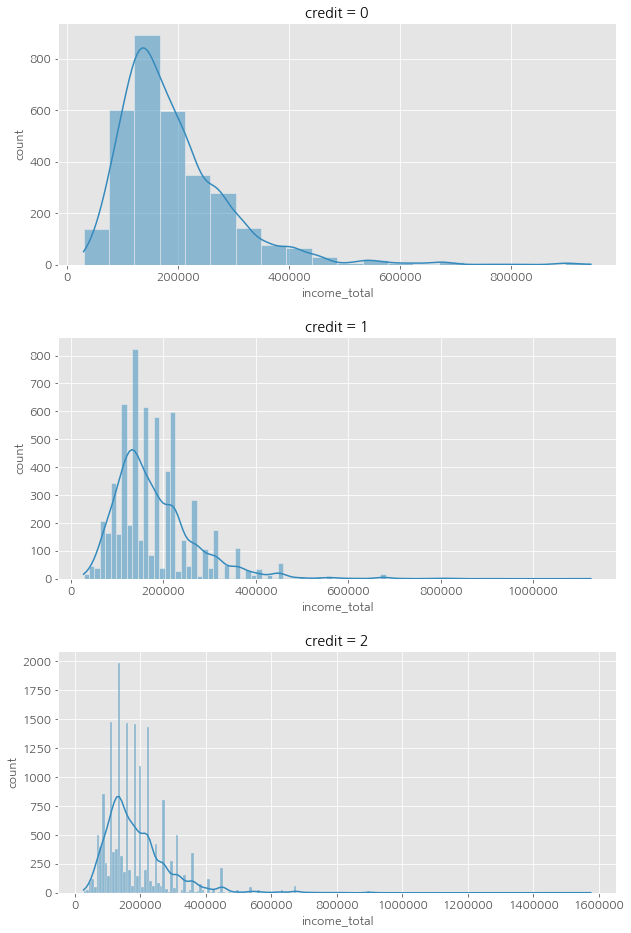

In [33]:
num_plot("income_total")

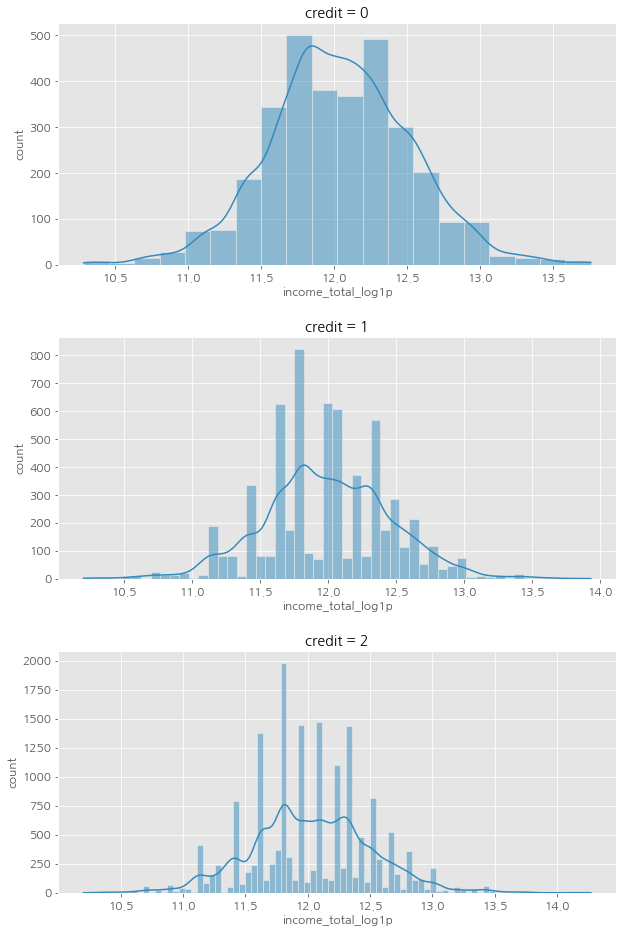

In [34]:
num_plot("income_total_log1p")

- 신용 등급에 따라 연간 소득 차이는 없어 보인다.

좀 더 자세히 비교해 보기 위해 그래프를 겹쳐서 그려보았다.


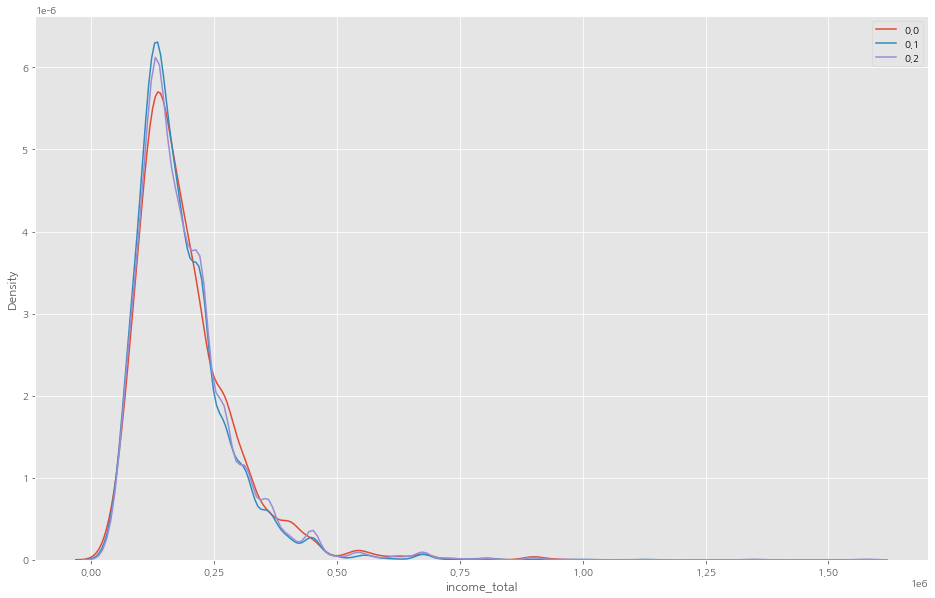

In [35]:
plt.figure(figsize = (16,10))
sns.distplot(train_0['income_total'],label='0.0', hist=False)
sns.distplot(train_1['income_total'],label='0.1', hist=False)
sns.distplot(train_2['income_total'],label='0.2', hist=False)
plt.legend()

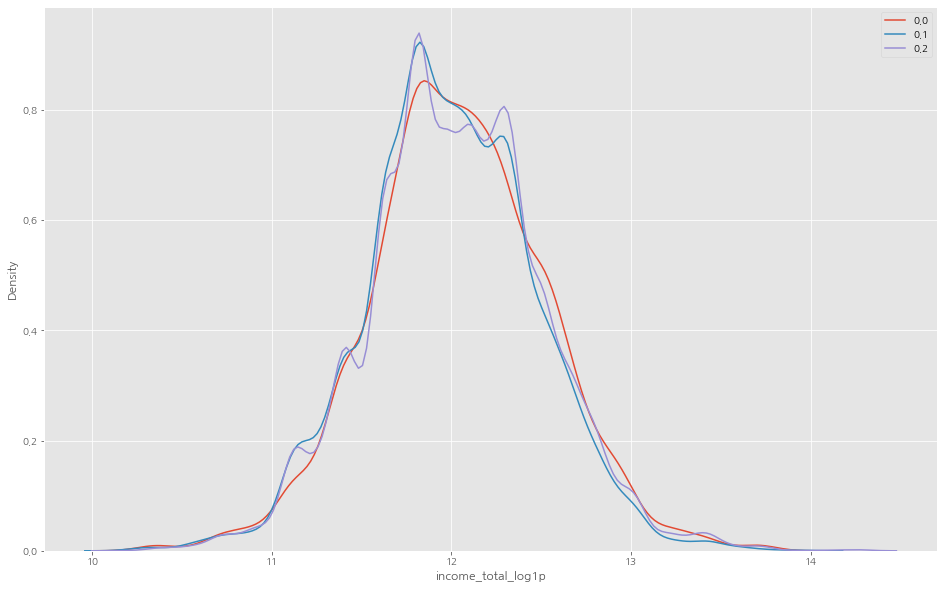

In [36]:
plt.figure(figsize = (16,10))
sns.distplot(train_0['income_total_log1p'],label='0.0', hist=False)
sns.distplot(train_1['income_total_log1p'],label='0.1', hist=False)
sns.distplot(train_2['income_total_log1p'],label='0.2', hist=False)
plt.legend()

- 겹처서 확인했을때도 별다른 차이가 없어 보인다.


### 👵🏻👧🏻👩🏻‍🦱 **신용 등급에 따라 연령대 차이가 존재할까?**

데이터 전처리를 통해 Age 변수를 도출하였습니다.

In [37]:
train_0['Age'] = abs(train_0['DAYS_BIRTH'])/360
train_1['Age'] = abs(train_1['DAYS_BIRTH'])/360
train_2['Age'] = abs(train_2['DAYS_BIRTH'])/360
train_0['Age'].head()

3     41.911111
7     41.377778
12    33.161111
15    35.719444
22    42.216667
Name: Age, dtype: float64

In [38]:
train_0 = train_0.astype({'Age': 'int'})
train_1 = train_1.astype({'Age': 'int'})
train_2 = train_2.astype({'Age': 'int'})
train_0['Age'].head()

3     41
7     41
12    33
15    35
22    42
Name: Age, dtype: int32

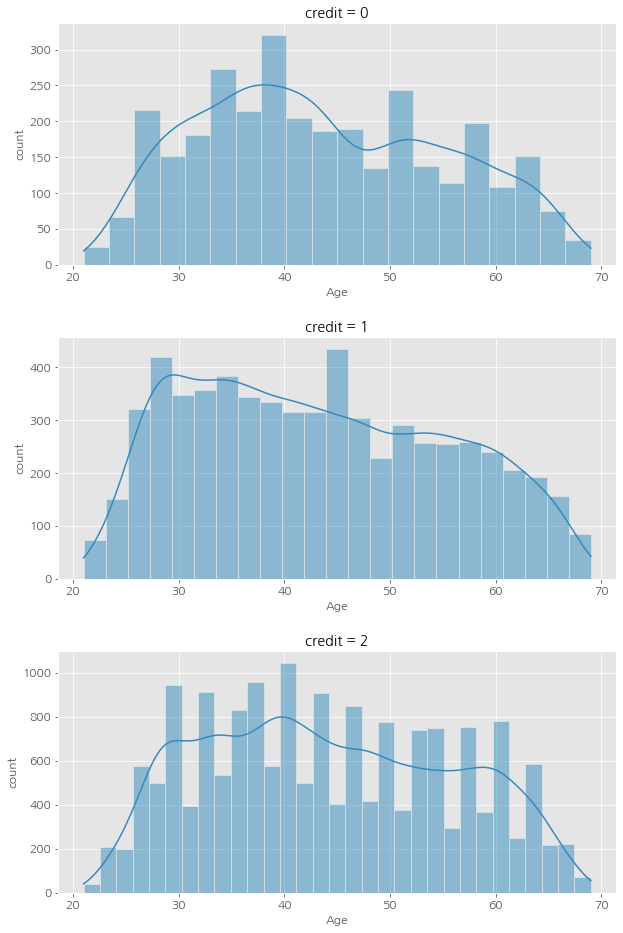

In [39]:
num_plot("Age")

- 등급별로 큰 차이는 없어 보이지만, 20~30대의 경우 비율이 낮은 것으로 나타났습니다.


DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
FLAG_MOBIL         int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit            object

### **🗓신용 등급에 따라 업무 기간 차이가 존재할까?**

업무 기간을 연도 단위로 분석해 보기 위해 전처리를 진행하였습니다.  

양수는 고용되지 않은 상태로 무직을 의미하기 때문에 0으로 대체를 하도록 하겠습니다.

In [40]:
train_0['EMPLOYED']= train_0['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train_1['EMPLOYED']= train_1['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train_2['EMPLOYED']= train_2['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train_0['EMPLOYED'] = abs(train_0['EMPLOYED'])/360
train_1['EMPLOYED'] = abs(train_1['EMPLOYED'])/360
train_2['EMPLOYED'] = abs(train_2['EMPLOYED'])/360
train_0['EMPLOYED'].head()

3     5.811111 
7     15.055556
12    6.005556 
15    11.266667
22    3.769444 
Name: EMPLOYED, dtype: float64

In [41]:
train_0 = train_0.astype({'EMPLOYED': 'int'})
train_1 = train_1.astype({'EMPLOYED': 'int'})
train_2 = train_2.astype({'EMPLOYED': 'int'})

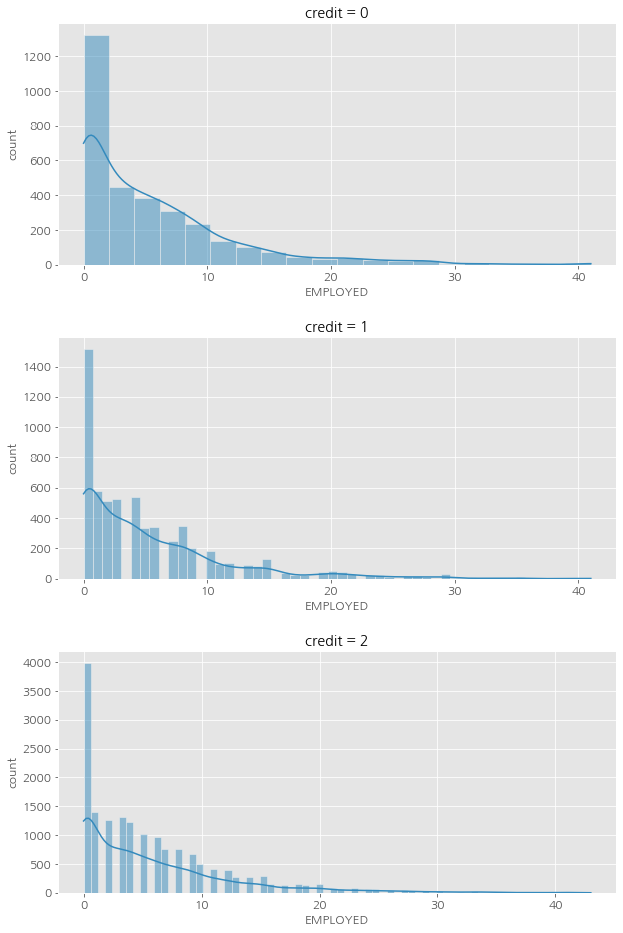

In [42]:
num_plot("EMPLOYED")

- 대체적으로 직업이 없는 사람들이 많습니다.
- 등급별로 별다른 차이는 없었습니다.

### **💳 신용 등급에 따라 카드 발급 기간 차이가 존재할까?**

In [43]:
# 🎍🎏🎗🎠🧥👗

SyntaxError: invalid character '🎍' (U+1F38D) (Temp/ipykernel_13108/1607709032.py, line 1)

전처리를 진행 후 Month 변수를 도출하였습니다.


In [44]:
train_0['Month'] = abs(train_0['begin_month'])
train_1['Month'] = abs(train_1['begin_month'])
train_2['Month'] = abs(train_2['begin_month'])
train_0 = train_0.astype({'Month': 'int'})
train_1 = train_1.astype({'Month': 'int'})
train_2 = train_2.astype({'Month': 'int'})
train_0['Month'].head()

3     37
7     53
12    60
15    60
22    22
Name: Month, dtype: int32

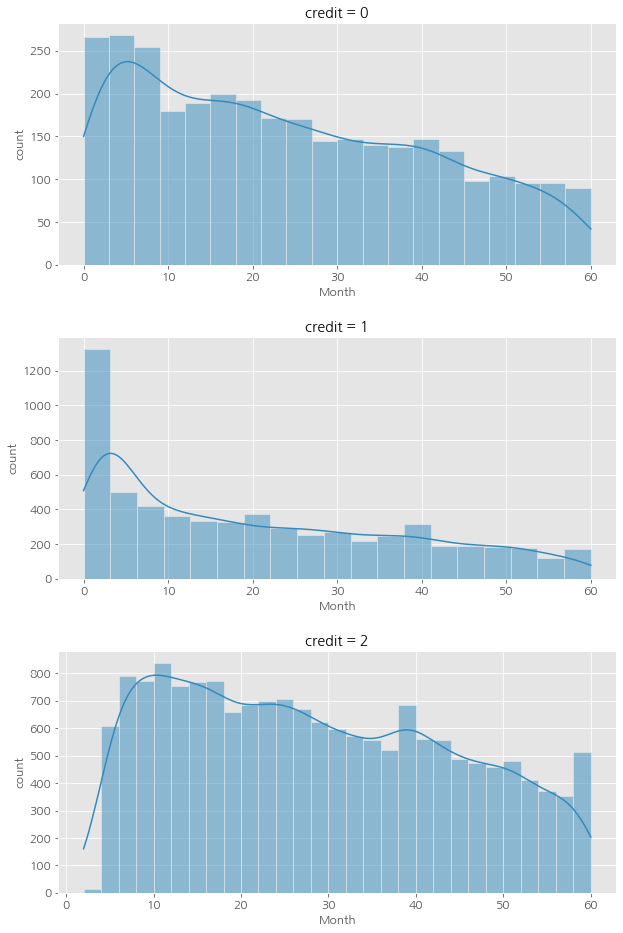

In [45]:
num_plot("Month")

- 대부분 카드를 발급 받은지 10달 이하인 사람들이 많았습니다.

In [46]:
#음수인 값을 양수로 변경
feats = ['DAYS_BIRTH', 'begin_month']
train[feats]=np.abs(train[feats])

In [47]:
#추기 컬럼 생성
df = train.copy()

In [48]:
# before_EMPLOYED: 고용되기 전까지의 일수
df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

#DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
df['Age'] = df['DAYS_BIRTH'] // 365
df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)


#DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

#ability: 소득/(살아온 일수+ 근무일수)
df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])

#income_mean: 소득/ 가족 수
df['income_mean'] = df['income_total'] / df['family_size']

#ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
df['ID'] = \
df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [49]:
# Count 컬럼 생성
df_ID = df['ID'].value_counts().reset_index()
df_ID.rename({'index':'ID', 'ID':'counting'}, axis =1 , inplace=True)
df['counting'] = 1
func = lambda x: df_ID['counting'].values[df_ID['counting'][df_ID['ID'] == x].index][0]
df['counting'] = df['ID'].apply(func)

In [50]:
train = df.copy()

In [51]:
encoder = OrdinalEncoder()
train['ID_num'] = encoder.fit_transform(train['ID'], train['credit'])

In [52]:
train = train.astype({'credit': 'object'})
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]

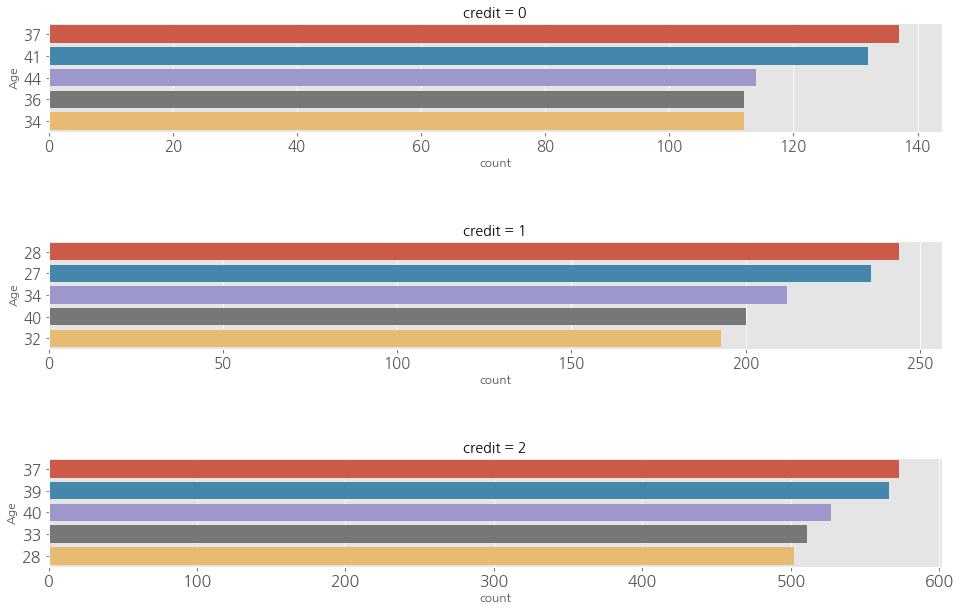

In [53]:
cat_plot("Age")

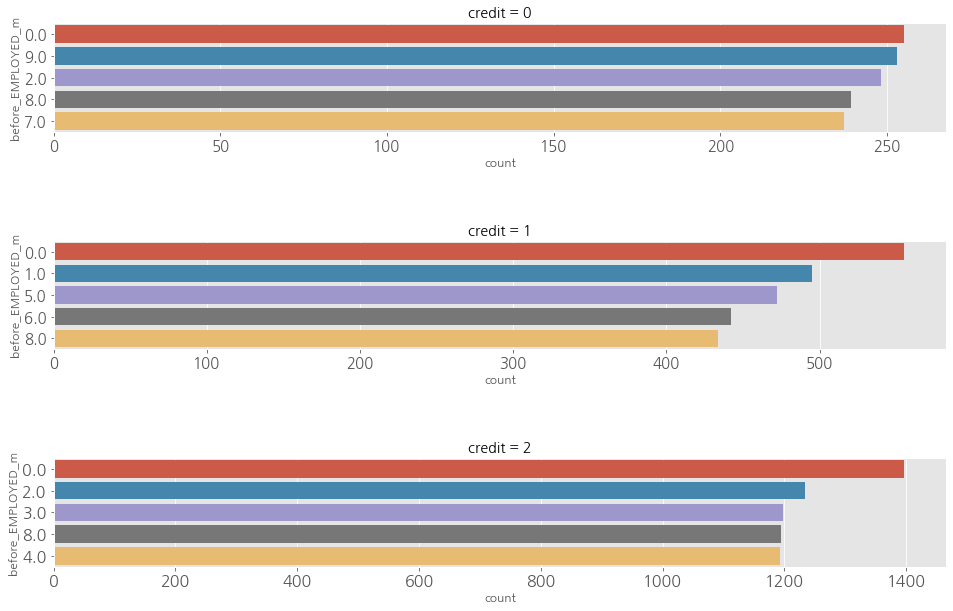

In [54]:
cat_plot("before_EMPLOYED_m")

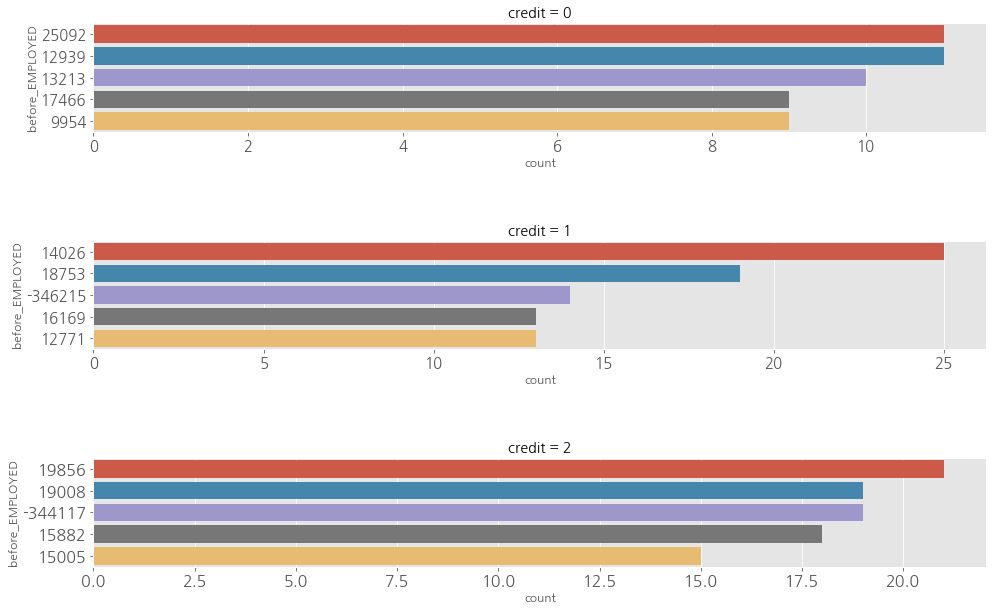

In [55]:
cat_plot("before_EMPLOYED")

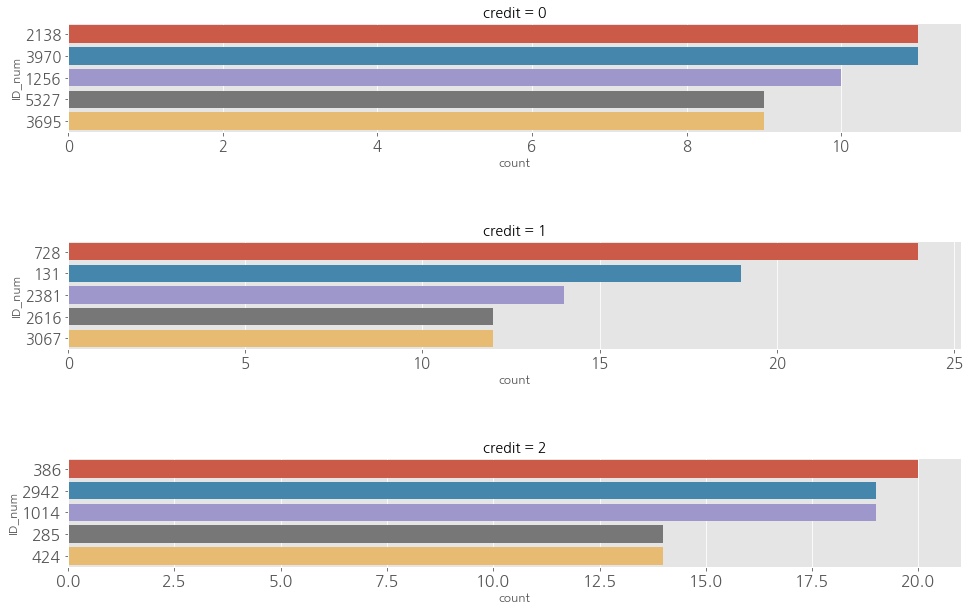

In [56]:
cat_plot("ID_num")

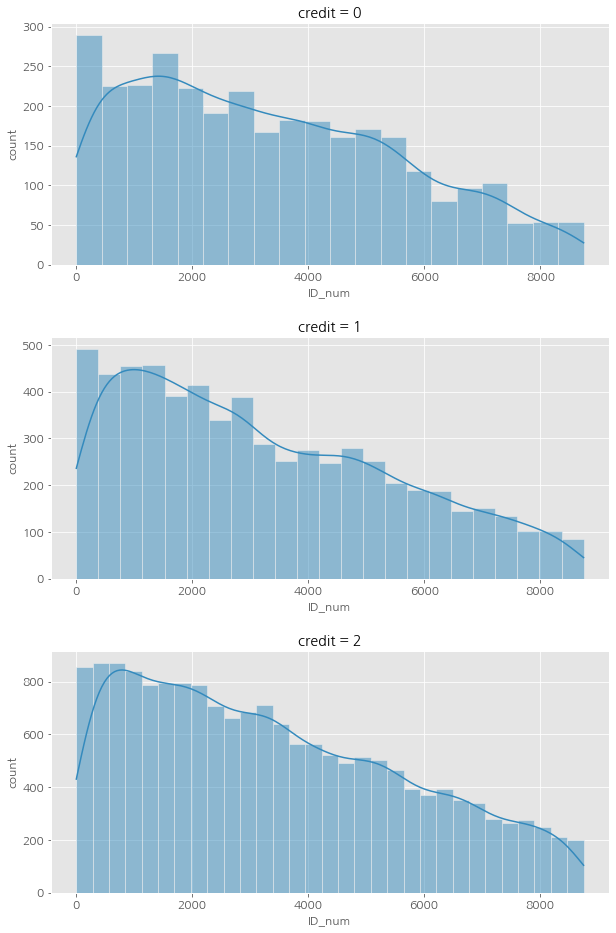

In [57]:
num_plot("ID_num")

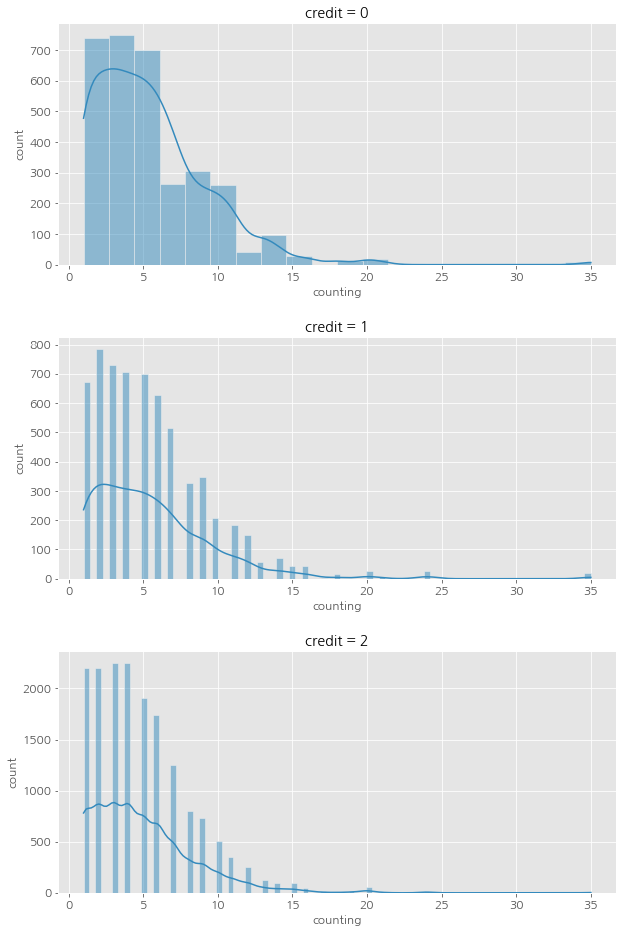

In [58]:
num_plot('counting')

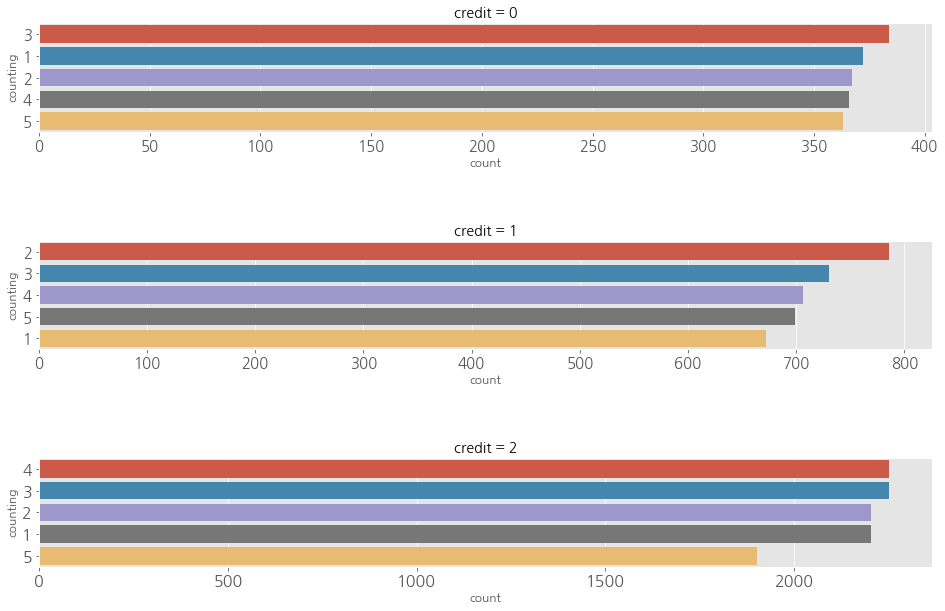

In [59]:
cat_plot("counting")

In [60]:
#people컬럼 생성

In [61]:
# Count 컬럼 생성
df_ID = df['ID'].value_counts().reset_index()
df_ID.rename({'index':'ID', 'ID':'counting'}, axis =1 , inplace=True)
df['counting'] = 1
func = lambda x: df_ID['counting'].values[df_ID['counting'][df_ID['ID'] == x].index][0]
df['counting'] = df['ID'].apply(func)

In [62]:
temp = train['counting'].value_counts().reset_index()

In [63]:
temp = temp.sort_values(by='index', ascending=False).rename({'index' : 'count'}, axis=1)

In [64]:
temp['people'] = temp['counting'] / temp['count']

In [65]:
temp.shape

(23, 3)

In [66]:
temp.reset_index(inplace = True)

In [67]:
temp.drop(['index','counting'], axis= 1, inplace =True)

In [68]:
temp2 = train.ID.value_counts().reset_index().head(10)

In [69]:
temp2

,index,ID
0,0_297000.0_15519_-3234_0_0_0_1.0_F_N_Y_Commercial associate_Secondary / secondary special_Single / not married_Rented apartment_Laborers,35
1,2_225000.0_16768_-3088_1_0_0_4.0_M_N_N_Working_Higher education_Civil marriage_House / apartment_Laborers,24
2,1_157500.0_12676_-1350_0_0_0_2.0_F_N_Y_State servant_Secondary / secondary special_Widow_House / apartment_Waiters/barmen staff,24
3,0_112500.0_9952_-1613_0_0_0_1.0_M_Y_Y_Working_Secondary / secondary special_Single / not married_House / apartment_freelancer,21
4,0_202500.0_21126_365243_0_0_0_1.0_F_N_Y_Pensioner_Secondary / secondary special_Widow_House / apartment_inoccupation,20
5,0_225000.0_12322_-3717_0_0_0_2.0_F_Y_Y_Working_Higher education_Married_House / apartment_Core staff,20
6,0_225000.0_22976_365243_0_0_0_1.0_F_N_Y_Pensioner_Secondary / secondary special_Single / not married_House / apartment_inoccupation,20
7,1_135000.0_10112_-3170_1_1_0_3.0_F_N_Y_Working_Secondary / secondary special_Married_House / apartment_Laborers,20
8,1_562500.0_13790_-5639_1_1_0_3.0_M_N_Y_Working_Incomplete higher_Married_House / apartment_freelancer,20
9,0_130500.0_13520_-5488_0_0_0_2.0_F_N_Y_Working_Secondary / secondary special_Married_House / apartment_Core staff,19


In [310]:
temp.head(10)

,count,people
0,35,1.0
1,24,2.0
2,21,1.0
3,20,5.0
4,19,1.0
5,18,2.0
6,17,1.0
7,16,7.0
8,15,10.0
9,14,15.0


In [309]:
temp = temp.sort_values(by='people', ascending=False)
temp = temp.sort_values(by='count', ascending=False)

In [70]:
temp3 = pd.concat([temp, temp2['index']], axis = 1)

In [71]:
temp3.rename({'index' : 'ID'}, axis =1 ,inplace = True)

In [72]:
temp3.head(10)

,count,people,ID
0,35,1.0,0_297000.0_15519_-3234_0_0_0_1.0_F_N_Y_Commercial associate_Secondary / secondary special_Single / not married_Rented apartment_Laborers
1,24,2.0,2_225000.0_16768_-3088_1_0_0_4.0_M_N_N_Working_Higher education_Civil marriage_House / apartment_Laborers
2,21,1.0,1_157500.0_12676_-1350_0_0_0_2.0_F_N_Y_State servant_Secondary / secondary special_Widow_House / apartment_Waiters/barmen staff
3,20,5.0,0_112500.0_9952_-1613_0_0_0_1.0_M_Y_Y_Working_Secondary / secondary special_Single / not married_House / apartment_freelancer
4,19,1.0,0_202500.0_21126_365243_0_0_0_1.0_F_N_Y_Pensioner_Secondary / secondary special_Widow_House / apartment_inoccupation
5,18,2.0,0_225000.0_12322_-3717_0_0_0_2.0_F_Y_Y_Working_Higher education_Married_House / apartment_Core staff
6,17,1.0,0_225000.0_22976_365243_0_0_0_1.0_F_N_Y_Pensioner_Secondary / secondary special_Single / not married_House / apartment_inoccupation
7,16,7.0,1_135000.0_10112_-3170_1_1_0_3.0_F_N_Y_Working_Secondary / secondary special_Married_House / apartment_Laborers
8,15,10.0,1_562500.0_13790_-5639_1_1_0_3.0_M_N_Y_Working_Incomplete higher_Married_House / apartment_freelancer
9,14,15.0,0_130500.0_13520_-5488_0_0_0_2.0_F_N_Y_Working_Secondary / secondary special_Married_House / apartment_Core staff


In [73]:
temp3 = temp3[['ID', 'count', 'people']]

In [75]:
temp3.head(10)

,ID,count,people
0,0_297000.0_15519_-3234_0_0_0_1.0_F_N_Y_Commercial associate_Secondary / secondary special_Single / not married_Rented apartment_Laborers,35,1.0
1,2_225000.0_16768_-3088_1_0_0_4.0_M_N_N_Working_Higher education_Civil marriage_House / apartment_Laborers,24,2.0
2,1_157500.0_12676_-1350_0_0_0_2.0_F_N_Y_State servant_Secondary / secondary special_Widow_House / apartment_Waiters/barmen staff,21,1.0
3,0_112500.0_9952_-1613_0_0_0_1.0_M_Y_Y_Working_Secondary / secondary special_Single / not married_House / apartment_freelancer,20,5.0
4,0_202500.0_21126_365243_0_0_0_1.0_F_N_Y_Pensioner_Secondary / secondary special_Widow_House / apartment_inoccupation,19,1.0
5,0_225000.0_12322_-3717_0_0_0_2.0_F_Y_Y_Working_Higher education_Married_House / apartment_Core staff,18,2.0
6,0_225000.0_22976_365243_0_0_0_1.0_F_N_Y_Pensioner_Secondary / secondary special_Single / not married_House / apartment_inoccupation,17,1.0
7,1_135000.0_10112_-3170_1_1_0_3.0_F_N_Y_Working_Secondary / secondary special_Married_House / apartment_Laborers,16,7.0
8,1_562500.0_13790_-5639_1_1_0_3.0_M_N_Y_Working_Incomplete higher_Married_House / apartment_freelancer,15,10.0
9,0_130500.0_13520_-5488_0_0_0_2.0_F_N_Y_Working_Secondary / secondary special_Married_House / apartment_Core staff,14,15.0


In [306]:
temp.head(10)

,count,people
22,1,3248.0
21,2,1679.0
20,3,1122.0
19,4,831.0
18,5,593.0
17,6,450.0
16,7,290.0
15,8,161.0
14,9,136.0
13,10,86.0


In [77]:
import math

In [89]:
math.log(0.51)

-0.6733445532637656

In [307]:
temp['people'].sum()

8756.0

In [396]:
# Numerical 그래프 함수 정의
def num_plot_(column):
  
  fig, axes = plt.subplots(1, 3, figsize=(20, 8))

  sns.histplot(train_0[column],
                ax = axes[0], kde = True, bins = 20)
  axes[0].ticklabel_format(style='plain', axis='x')  
  axes[0].tick_params(labelsize=12)
  axes[0].set_title('credit = 0')
  axes[0].set_ylabel('count')

  sns.histplot(train_1[column],
                ax = axes[1], kde = True)
  axes[1].tick_params(labelsize=12)
  axes[1].ticklabel_format(style='plain', axis='x')  
  axes[1].set_title('credit = 1')
  axes[1].set_ylabel('count')

  sns.histplot(train_2[column],
                ax = axes[2], kde = True)
  axes[2].tick_params(labelsize=12)
  axes[2].ticklabel_format(style='plain', axis='x')  
  axes[2].set_title('credit = 2')
  axes[2].set_ylabel('count')
  plt.subplots_adjust(wspace=0.3, hspace=0.3)

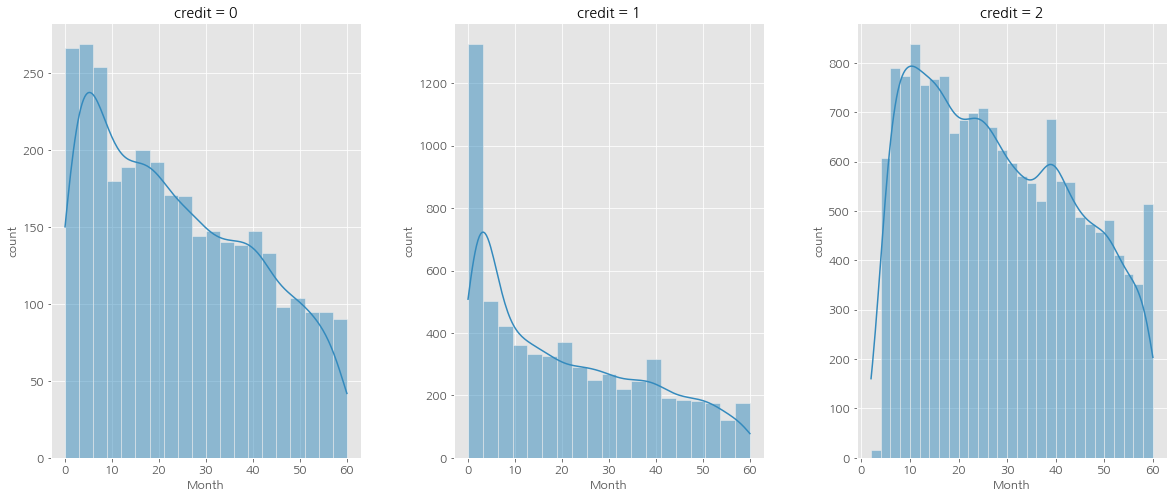

In [397]:
num_plot_('Month')